# Self-Driving Car Engineer Nanodegree


## Project2: ** Advanced Lane Finding** 

** Solution by luk6xff (May 2019)
** Writeup here: [P2 writeup](WRITEUP.md)

### In this project, a goal is to write a software pipeline to identify the lane boundaries in a video.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
# Importing some useful packages used in the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.081920/28549024 bytes (0.3%360448/28549024 bytes (1.3704512/28549024 bytes (2.5933888/28549024 bytes (3.3950272/28549024 bytes (3.31884160/28549024 bytes (6.6%2195456/28549024 bytes (7.7%2523136/28549024 bytes (8.8%2859008/28549024 bytes (10.03219456/28549024 bytes (11.33563520/28549024 bytes (12.53923968/28549024 bytes (13.74284416/28549024 bytes (15.04628480/28549024 bytes (16.24988928/28549024 bytes (17.55349376/28549024 bytes (18.75709824/28549024 bytes (20.06070272/28549024 bytes (21.36422528/28549024 bytes (22.56758400/28549024 bytes (23.77118848/28549024 bytes (24.97479296/28549024 bytes (26.27839744/28549024 bytes (27.58183808/28549024 bytes (28.78511488/28549024 bytes (29.88757248/28549024 bytes (30.79084928/28549024 bytes (31.89428992/28549024 bytes (33.0977

## 1. Camera calibration and distortion coefficients 

Camera intrinsic matrix:
[[  1.15777942e+03   0.00000000e+00   6.67111049e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129069e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients:
[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259138]]


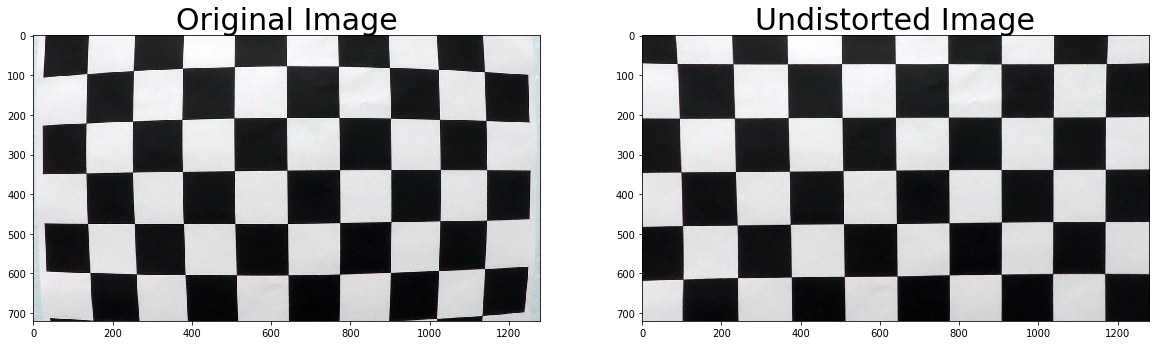

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Based on used images (camera_cal/calibration*.jpg), I set the number of corners
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
#print(objp[:,:2])
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), cv2.CALIB_CB_ADAPTIVE_THRESH)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # Save the images
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cols = 8
        #rows = 1
        #plt.figure(figsize=(50,70))
        #plt.subplot(cols, rows, (idx%8)+1)
        #plt.imshow(img)

# Test undistortion on an image
img      = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, cam_mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistorted_img = cv2.undistort(img, cam_mtx, dist_coeffs, None, cam_mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# cam_mtx     = [fx  0  cx]
#               [0  fy  cy]
#               [0   0   1]
# dist_coeffs = [k1, k2, p1, p2, k3]
dist_pickle = {}
dist_pickle["cam_mtx"] = cam_mtx
dist_pickle["dist_coeffs"] = dist_coeffs
print('Camera intrinsic matrix:\n{}'.format(cam_mtx))
print('Camera distortion coefficients:\n{}'.format(dist_coeffs))
pickle.dump(dist_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))

# Print the calibration results - original (distorted) image, and undistorted one.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

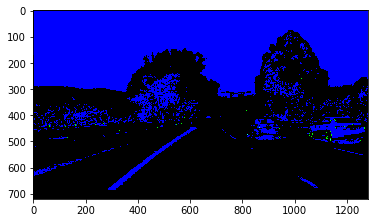

In [3]:
def apply_threshold(img, grad_thresh=(20,100), s_color_thresh=(90,255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] #Saturation channel
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find sobel gradient
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x  = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))*255
    return color_binary

# Test on a test image
img = cv2.imread('test_images/test1.jpg')
plt.imshow(apply_threshold(img, grad_thresh=(150,200), s_color_thresh=(90,255)), cmap='gray')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").